In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.ndimage.filters import gaussian_filter as gf

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle as Rec

from skimage import filters
from skimage import transform as tf

import csv
import json
import random
import urllib
from PIL import Image

import sys, os
import pandas as pd
import pickle
from datetime import datetime

from projEdgeBreaks import *
from imageModifiers import *
from saveImages import *
from plottingFuncs import *

# change pandas parameter
pd.options.mode.chained_assignment = None
# change plot size
mpl.rcParams["figure.figsize"] = (15, 15)

## Specify file and folder locations

In [2]:
consensusFolder = "C:/Users/danny/Repos/text_segmentation/consensus/consensus/"
consensusFile = consensusFolder + "decoding-the-civil-war-consensus-linewise_{mss_label}.csv"
lineInfo = consensusFolder + "dataWithLineIDs_subset_{mss_label}.pkl"
subjFile = "data/decoding-the-civil-war-subjects-9-29-17.csv"

## This will late be in a loop - get hdl_id

In [3]:
# mssLabel = sampleDataFileName.split('/')[-1][len(
#     'classification_export_'):-4]
mssLabel = "fication_export_mssEC_02_05_25_17"
consensusFile = consensusFile.format(mss_label=mssLabel)
lineInfo = lineInfo.format(mss_label=mssLabel) 

### Read data files

In [4]:
# subject file
subj = pd.read_csv(subjFile)
# get only the workflow from the live project
subj = subj.loc[subj['workflow_id'] == 1874]

# get metadata in dictionary format
subj["meta_json"] = [json.loads(q) for q in subj["metadata"]]
# get hdl_id from metadata
subj["hdl_id"] = [q.get("hdl_id", "mssF") for q in subj["meta_json"]]
# get image url
subj["url"] = [json.loads(q).get("0") for q in subj["locations"]]

# remove images without ids
subj = subj[subj["hdl_id"] != "mssF"]
# remove codebook images (mssEC_36-67)
filt = subj["hdl_id"].str.contains("mssEC_3[6-9]|[4-6][0-9]")
subj = subj[~filt]
# remove ledgers that seemed weird (only easy stuff for now)
filt = subj["hdl_id"].str.contains("mssEC_3[0-3]|2[6-9]")
subj = subj[~filt]
# remove the first few pages because they tended to be blank
filt = subj["hdl_id"].str.contains("mssEC_\d\d_00[1-6]")
subj = subj[~filt]

# consensus file (by line)
cons = pd.read_csv(consensusFile, sep="@@", engine="python").drop_duplicates()

# combine the two and sift out unneeded columns
allTelegramInfo = pd.merge(cons, subj, on="hdl_id", suffixes=["_cons", "_subj"])
idAndUrl = allTelegramInfo.loc[:,["hdl_id", "url_cons"]].drop_duplicates()
transcriptionsByLine = allTelegramInfo.loc[:,["hdl_id", "bestLineIndex", "consensus_text", 
                                       "y_loc", "len_wordlist"]]

In [5]:
# for each image:
i = 0
hdl_id = idAndUrl.loc[i, "hdl_id"]
let, grey = readImg(idAndUrl.loc[i, "url_cons"])#, True)
linesForTele = transcriptionsByLine.loc[transcriptionsByLine["hdl_id"] == hdl_id]
linesForTele.loc[:,"y1"] = [eval(l)[0] for l in linesForTele.loc[:,"y_loc"]]

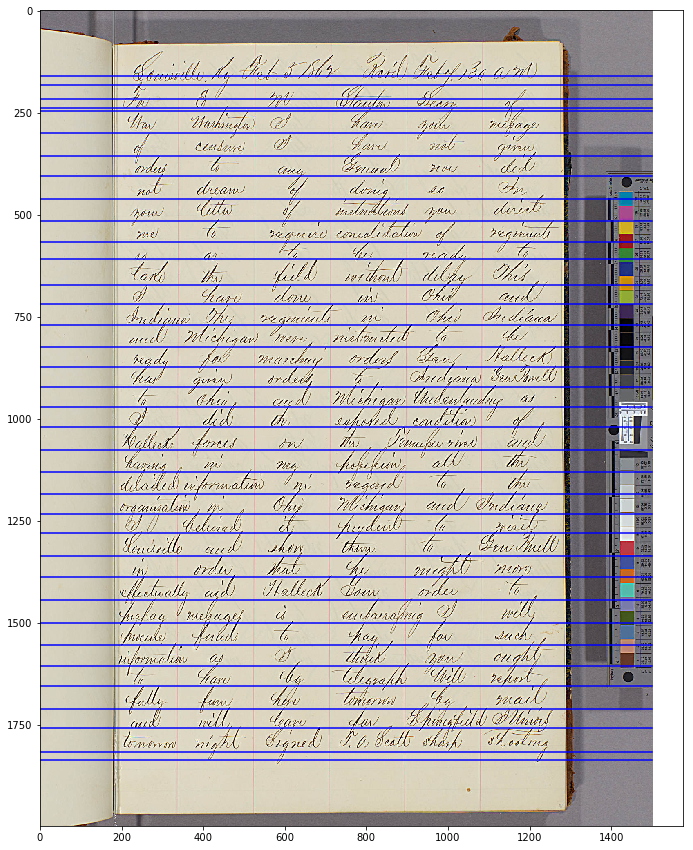

In [7]:
plotBoxes(let, linesForTele.loc[:, "y1"])

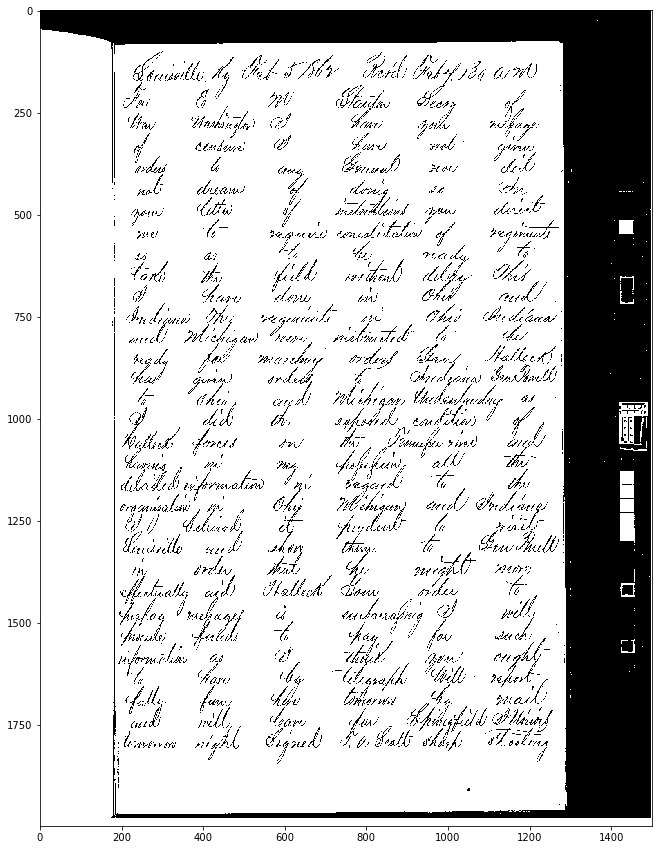

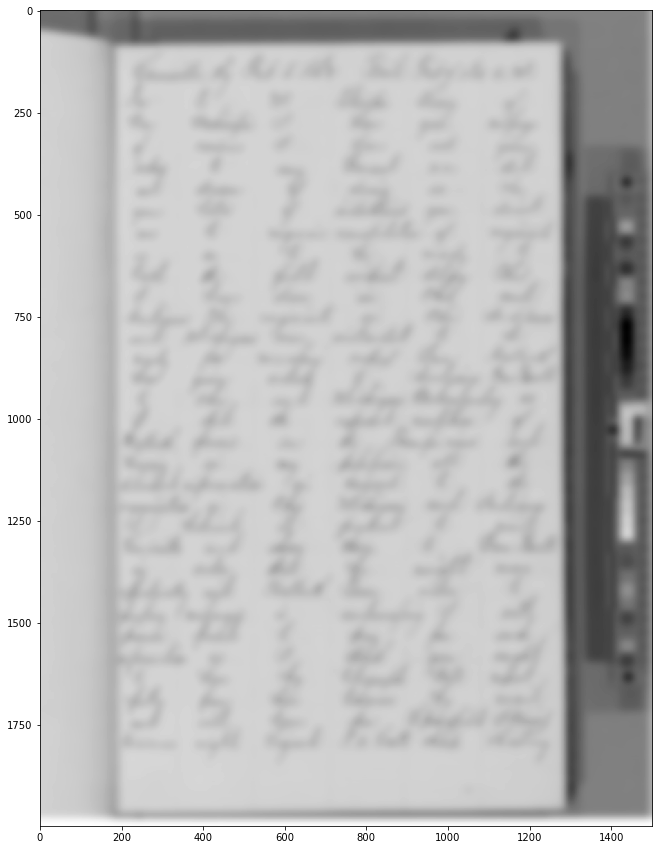

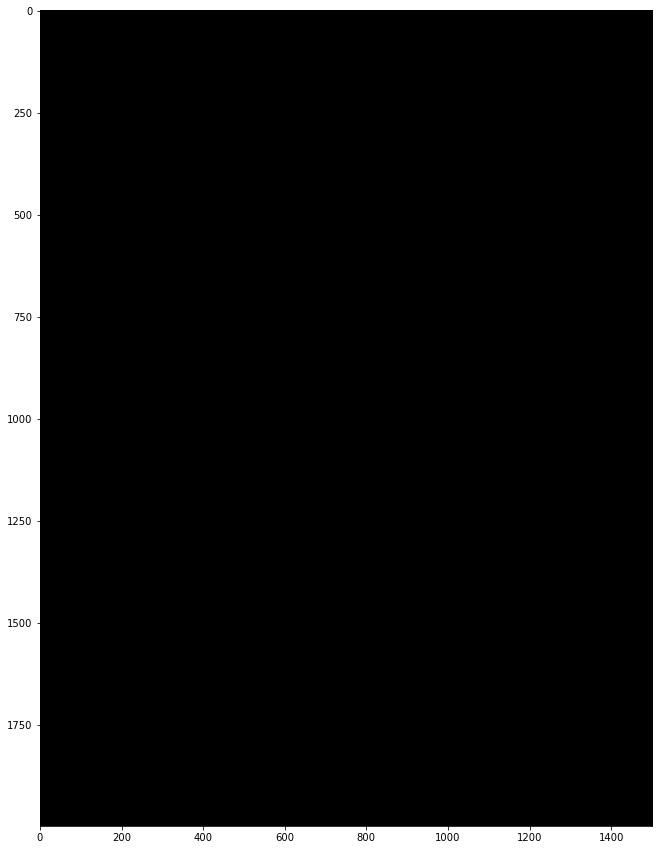

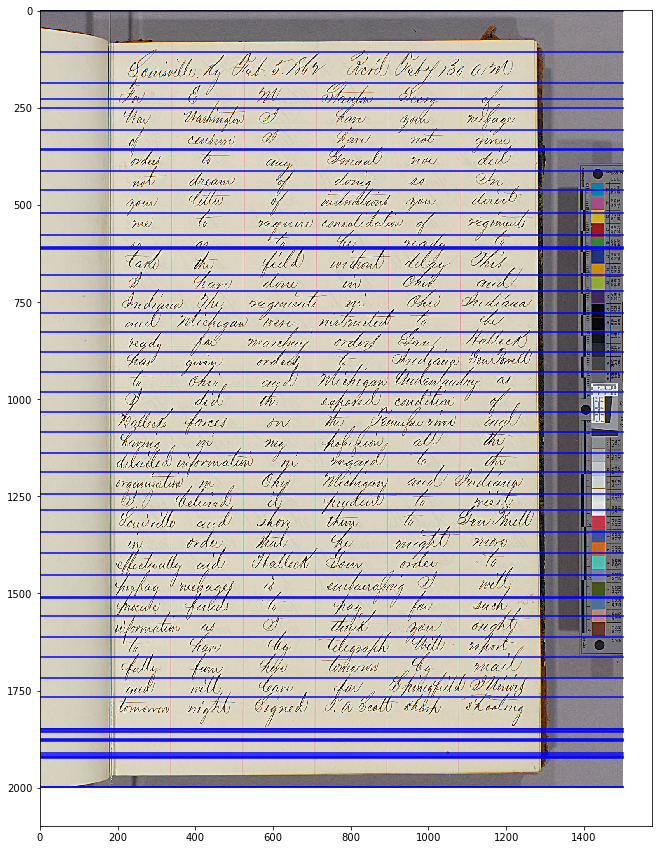

In [9]:
# read in and do all pre-processing #################################
let, grey = removeEdges(let, grey, rmThresh=0)
grey = whitenEdgesProject(grey)
greyBi = binarizeImg(grey, biThresh="otsu", plotIt=True)
greySm = smoothImg(grey, smoothSigma=10.0, plotIt=True)
greyBiSm = smoothImg(greyBi, smoothSigma=5.0, plotIt=True)


# get linebreaks ####################################################
lb = projBreaks(greySm, "y")
plotBoxes(let, lb)